### Standardized train-test split of mushroom data

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Load the dataset
df = pd.read_csv("mushroom2.csv")

# 2. Fill the real-missing values with "?"
df = df.fillna("?")

# 3. Drop useless columns identified from EDA (gill-attachment, veil-type)
df = df.drop(columns=["veil-type"])

# 4. Separate features and target
X = df.drop("class", axis=1)
y = df["class"]

# 5. Perform 80–20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y)

### LDA & QDA

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.base import clone
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [5]:
categorical_features = X.columns.tolist()

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Column transformer that applies OHE to all features
preprocess = ColumnTransformer(
    transformers=[
        ("cat", ohe, categorical_features)
    ]
)

# LDA pipeline
lda_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("lda", LinearDiscriminantAnalysis())
])

# QDA pipeline
qda_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("qda", QuadraticDiscriminantAnalysis())
])

In [6]:
# ---- LDA ----
lda_clf.fit(X_train, y_train)
y_proba_lda = lda_clf.predict_proba(X_test)[:, 1]
threshold = 0.30
y_pred_lda = np.where(y_proba_lda >= threshold, "p", "e")

print("LDA Accuracy:", accuracy_score(y_test, y_pred_lda))

cm_lda = confusion_matrix(y_test, y_pred_lda)
TN, FP, FN, TP = cm_lda.ravel()
TPR = TP / (TP + FN)
FNR = FN / (TP + FN)
FPR = FP / (FP + TN)
TNR = TN / (TN + FP)

print(f"\nTrue Positive Rate (TPR): {TPR:.4f}")
print(f"False Negative Rate (FNR): {FNR:.4f}")
print(f"False Positive Rate (FPR): {FPR:.4f}")
print(f"True Negative Rate (TNR): {TNR:.4f}")
f2 = fbeta_score(y_test, y_pred_lda, beta=2, pos_label="p")
print("f2:",f2)

print("\nLDA Confusion Matrix:")
print(cm_lda)

LDA Accuracy: 0.7089265101962293

True Positive Rate (TPR): 0.8788
False Negative Rate (FNR): 0.1212
False Positive Rate (FPR): 0.4288
True Negative Rate (TNR): 0.5712
f2: 0.8125397329942784

LDA Confusion Matrix:
[[1640 1231]
 [ 282 2045]]


In [7]:
# ---- QDA ----
qda_clf.fit(X_train, y_train)
y_proba_qda = qda_clf.predict_proba(X_test)[:, 1]
threshold = 0.20
y_pred_qda = np.where(y_proba_qda >= threshold, "p", "e")

print("QDA Accuracy:", accuracy_score(y_test, y_pred_qda))

cm_qda = confusion_matrix(y_test, y_pred_qda)
TN, FP, FN, TP = cm_qda.ravel()
TPR = TP / (TP + FN)
FNR = FN / (TP + FN)
FPR = FP / (FP + TN)
TNR = TN / (TN + FP)

print(f"\nTrue Positive Rate (TPR): {TPR:.4f}")
print(f"False Negative Rate (FNR): {FNR:.4f}")
print(f"False Positive Rate (FPR): {FPR:.4f}")
print(f"True Negative Rate (TNR): {TNR:.4f}")
f2 = fbeta_score(y_test, y_pred_qda, beta=2, pos_label="p")
print("f2:",f2)

print("\nQDA Confusion Matrix:")
print(cm_qda)

QDA Accuracy: 0.6077337437475953

True Positive Rate (TPR): 0.8595
False Negative Rate (FNR): 0.1405
False Positive Rate (FPR): 0.5963
True Negative Rate (TNR): 0.4037
f2: 0.7680491551459293

QDA Confusion Matrix:
[[1159 1712]
 [ 327 2000]]


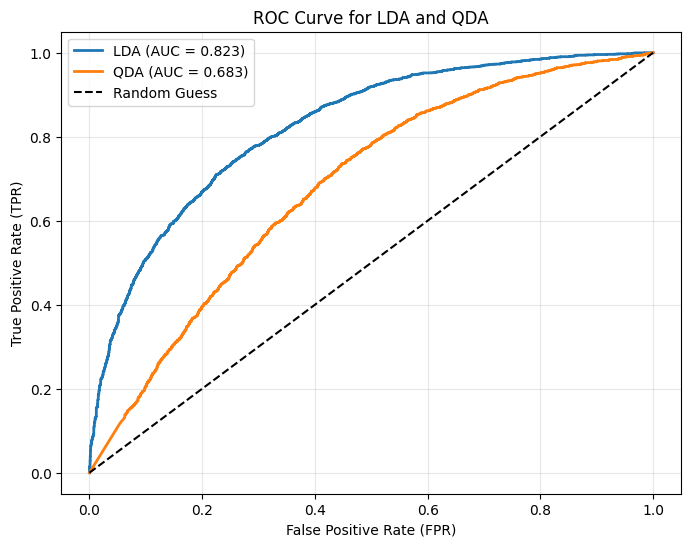

In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Compute ROC curve & AUC score

y_proba_lda = lda_clf.predict_proba(X_test)[:, 1]
y_proba_qda = qda_clf.predict_proba(X_test)[:, 1]

fpr_lda, tpr_lda, _ = roc_curve(y_test.map({'e':0, 'p':1}), y_proba_lda)
auc_lda = auc(fpr_lda, tpr_lda)

fpr_qda, tpr_qda, _ = roc_curve(y_test.map({'e':0, 'p':1}), y_proba_qda)
auc_qda = auc(fpr_qda, tpr_qda)

plt.figure(figsize=(8, 6))

plt.plot(fpr_lda, tpr_lda, label=f"LDA (AUC = {auc_lda:.3f})", linewidth=2)
plt.plot(fpr_qda, tpr_qda, label=f"QDA (AUC = {auc_qda:.3f})", linewidth=2)

plt.plot([0,1], [0,1], 'k--', label="Random Guess")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for LDA and QDA")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Random Forest & Boosting

In [9]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OrdinalEncoder

ordinal = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", ordinal, categorical_features)
    ]
)

# ---- Random Forest ----
rf_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    ))
])

rf_clf.fit(X_train, y_train)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]
threshold = 0.35
y_pred_rf = np.where(y_proba_rf >= threshold, "p", "e")

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
TN, FP, FN, TP = cm_rf.ravel()
TPR = TP / (TP + FN)
FNR = FN / (TP + FN)
FPR = FP / (FP + TN)
TNR = TN / (TN + FP)

print(f"\nTrue Positive Rate (TPR): {TPR:.4f}")
print(f"False Negative Rate (FNR): {FNR:.4f}")
print(f"False Positive Rate (FPR): {FPR:.4f}")
print(f"True Negative Rate (TNR): {TNR:.4f}")
f2 = fbeta_score(y_test, y_pred_rf, beta=2, pos_label="p")
print("f2:",f2)

print("\nRandom Forest Confusion Matrix:")
print(cm_rf)

Random Forest Accuracy: 0.683532127741439

True Positive Rate (TPR): 0.8969
False Negative Rate (FNR): 0.1031
False Positive Rate (FPR): 0.4894
True Negative Rate (TNR): 0.5106
f2: 0.815234375

Random Forest Confusion Matrix:
[[1466 1405]
 [ 240 2087]]


In [10]:
# ---- Gradient Boosting ----
gb_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("gb", GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ))
])

gb_clf.fit(X_train, y_train)
y_proba_gb = gb_clf.predict_proba(X_test)[:, 1]
threshold = 0.30
y_pred_gb = np.where(y_proba_gb >= threshold, "p", "e")

print("\nGradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))

cm_gb = confusion_matrix(y_test, y_pred_gb)
TN, FP, FN, TP = cm_gb.ravel()
TPR = TP / (TP + FN)
FNR = FN / (TP + FN)
FPR = FP / (FP + TN)
TNR = TN / (TN + FP)

print(f"\nTrue Positive Rate (TPR): {TPR:.4f}")
print(f"False Negative Rate (FNR): {FNR:.4f}")
print(f"False Positive Rate (FPR): {FPR:.4f}")
print(f"True Negative Rate (TNR): {TNR:.4f}")
f2 = fbeta_score(y_test, y_pred_gb, beta=2, pos_label="p")
print("f2:",f2)

print("\nGradient Boosting Confusion Matrix:")
print(cm_gb)


Gradient Boosting Accuracy: 0.7012312427856868

True Positive Rate (TPR): 0.8982
False Negative Rate (FNR): 0.1018
False Positive Rate (FPR): 0.4584
True Negative Rate (TNR): 0.5416
f2: 0.821928582664779

Gradient Boosting Confusion Matrix:
[[1555 1316]
 [ 237 2090]]


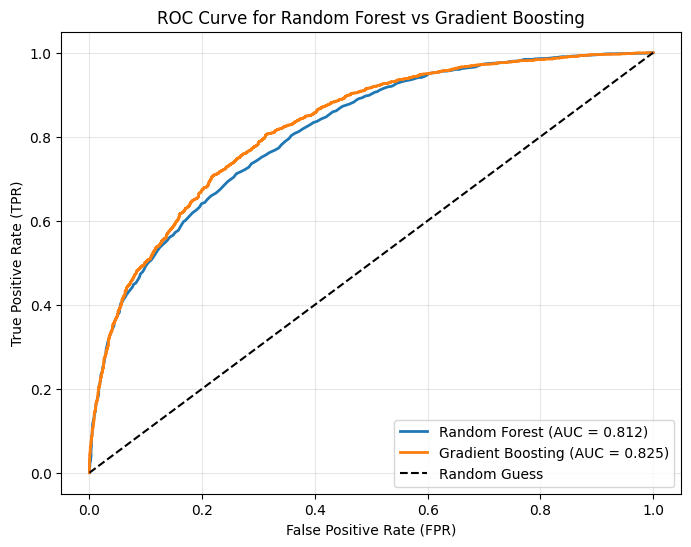

In [11]:
# Compute ROC curve & AUC score
y_proba_rf  = rf_clf.predict_proba(X_test)[:, 1]
y_proba_gb  = gb_clf.predict_proba(X_test)[:, 1]

y_test_binary = y_test.map({'e': 0, 'p': 1})

fpr_rf, tpr_rf, _ = roc_curve(y_test_binary, y_proba_rf)
auc_rf = auc(fpr_rf, tpr_rf)

fpr_gb, tpr_gb, _ = roc_curve(y_test_binary, y_proba_gb)
auc_gb = auc(fpr_gb, tpr_gb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})", linewidth=2)
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC = {auc_gb:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], "k--", label="Random Guess")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for Random Forest vs Gradient Boosting")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# ---- Logistic Regression ----

categorical_features = X.columns.tolist()

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Column transformer that applies OHE to all features
preprocess = ColumnTransformer(
    transformers=[
        ("cat", ohe, categorical_features)
    ]
)

logreg_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("scaler", StandardScaler(with_mean=False)),
    ("logreg", LogisticRegression(
        max_iter=2000,
        solver="lbfgs",
        n_jobs=-1
    ))
])

logreg_clf.fit(X_train, y_train)
y_proba_logreg = logreg_clf.predict_proba(X_test)[:, 1]
threshold = 0.30
y_pred_logreg = np.where(y_proba_logreg >= threshold, "p", "e")

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))

cm_logreg = confusion_matrix(y_test, y_pred_logreg, labels=["e", "p"])
TN, FP, FN, TP = cm_logreg.ravel()
TPR = TP / (TP + FN)
FNR = FN / (TP + FN)
FPR = FP / (FP + TN)
TNR = TN / (TN + FP)

print(f"\nTrue Positive Rate (TPR): {TPR:.4f}")
print(f"False Negative Rate (FNR): {FNR:.4f}")
print(f"False Positive Rate (FPR): {FPR:.4f}")
print(f"True Negative Rate (TNR): {TNR:.4f}")
f2 = fbeta_score(y_test, y_pred_logreg, beta=2, pos_label="p")
print("f2:",f2)

print("\nLogistic Regression Confusion Matrix:")
print(cm_logreg)

Logistic Regression Accuracy: 0.7083493651404387

True Positive Rate (TPR): 0.8887
False Negative Rate (FNR): 0.1113
False Positive Rate (FPR): 0.4378
True Negative Rate (TNR): 0.5622
f2: 0.8184912530673633

Logistic Regression Confusion Matrix:
[[1614 1257]
 [ 259 2068]]


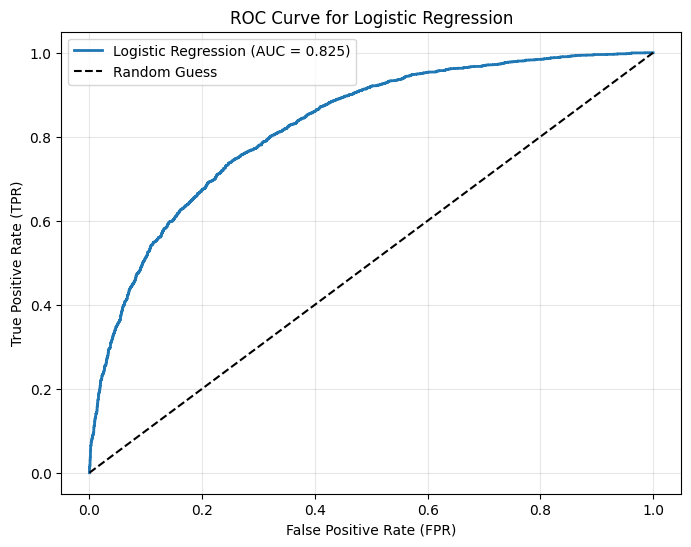

In [13]:
# Compute ROC curve & AUC score

y_proba_logreg = logreg_clf.predict_proba(X_test)[:, 1]

y_test_binary = y_test.map({'e': 0, 'p': 1})

fpr_logreg, tpr_logreg, _ = roc_curve(y_test_binary, y_proba_logreg)
auc_logreg = auc(fpr_logreg, tpr_logreg)

plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg,
         label=f"Logistic Regression (AUC = {auc_logreg:.3f})",
         linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for Logistic Regression")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### SVM

In [14]:
from sklearn.svm import SVC

# ----- SVM (RBF kernel) -----

svm_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("scale", StandardScaler(with_mean=False)),
    ("svm", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        class_weight="balanced",
        random_state=42
    ))
])

svm_clf.fit(X_train, y_train)
y_proba_svm = svm_clf.predict_proba(X_test)[:, 1]
threshold = 0.40
y_pred_svm = np.where(y_proba_svm >= threshold, "p", "e")

print("SVM (RBF) Accuracy:", accuracy_score(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm)
TN, FP, FN, TP = cm_svm.ravel()
TPR = TP / (TP + FN)
FNR = FN / (TP + FN)
FPR = FP / (FP + TN)
TNR = TN / (TN + FP)

print(f"\nTrue Positive Rate (TPR): {TPR:.4f}")
print(f"False Negative Rate (FNR): {FNR:.4f}")
print(f"False Positive Rate (FPR): {FPR:.4f}")
print(f"True Negative Rate (TNR): {TNR:.4f}")
f2 = fbeta_score(y_test, y_pred_svm, beta=2, pos_label="p")
print("f2:",f2)

print("\nSVM Confusion Matrix:")
print(cm_svm)

SVM (RBF) Accuracy: 0.7297037322046941

True Positive Rate (TPR): 0.7942
False Negative Rate (FNR): 0.2058
False Positive Rate (FPR): 0.3225
True Negative Rate (TNR): 0.6775
f2: 0.764774044032445

SVM Confusion Matrix:
[[1945  926]
 [ 479 1848]]



SVM ROC AUC: 0.8163


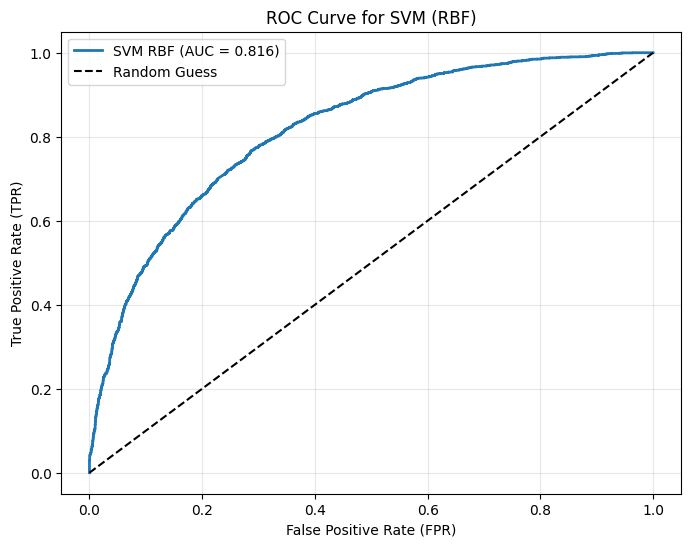

In [15]:
# Compute ROC curve & AUC score

y_proba_svm = svm_clf.predict_proba(X_test)[:, 1]  # prob of class 'p'

fpr_svm, tpr_svm, _ = roc_curve(y_test.map({'e': 0, 'p': 1}), y_proba_svm)
auc_svm = auc(fpr_svm, tpr_svm)

print(f"\nSVM ROC AUC: {auc_svm:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f"SVM RBF (AUC = {auc_svm:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for SVM (RBF)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

categorical_features = X.columns.tolist()

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Column transformer that applies OHE to all features
preprocess = ColumnTransformer(
    transformers=[
        ("cat", ohe, categorical_features)
    ]
)

X_train_encoded = ohe.fit_transform(X_train)
X_test_encoded = ohe.transform(X_test)
X_train_encoded = pd.DataFrame(X_train_encoded, columns=ohe.get_feature_names_out())
X_test_encoded = pd.DataFrame(X_test_encoded, columns=ohe.get_feature_names_out())
y_train_encoded = ohe.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = ohe.transform(y_test.values.reshape(-1, 1))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Hyperparameter Tuning with 5 fold Cross-validation

#define the model
knn = KNeighborsClassifier()

# Define the parameter grid
param_grid = {'n_neighbors': np.arange(1, 21)}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_encoded)

best_k = grid_search.best_params_['n_neighbors']
best_knn = grid_search.best_estimator_

print(f"\nBest 'k' value found: {best_k}")
print(f"Best cross-validation AUC: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best 'k' value found: 20
Best cross-validation AUC: 0.7573


In [17]:
knn_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(
        n_neighbors=20,
        weights="distance",
        n_jobs=-1
    ))
])

# ---- KNN ----
knn_clf.fit(X_train, y_train)

y_proba_knn = knn_clf.predict_proba(X_test)[:, 1]
threshold = 0.30
y_pred_knn = np.where(y_proba_knn >= threshold, "p", "e")

print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))

cm_knn = confusion_matrix(y_test, y_pred_knn)
TN, FP, FN, TP = cm_knn.ravel()
TPR = TP / (TP + FN)
FNR = FN / (TP + FN)
FPR = FP / (FP + TN)
TNR = TN / (TN + FP)

print(f"\nTrue Positive Rate (TPR): {TPR:.4f}")
print(f"False Negative Rate (FNR): {FNR:.4f}")
print(f"False Positive Rate (FPR): {FPR:.4f}")
print(f"True Negative Rate (TNR): {TNR:.4f}")
f2 = fbeta_score(y_test, y_pred_knn, beta=2, pos_label="p")
print("f2:",f2)

print("\nKNN Confusion Matrix:")
print(cm_knn)

KNN Accuracy: 0.600808003078107

True Positive Rate (TPR): 0.8930
False Negative Rate (FNR): 0.1070
False Positive Rate (FPR): 0.6360
True Negative Rate (TNR): 0.3640
f2: 0.7864062973054798

KNN Confusion Matrix:
[[1045 1826]
 [ 249 2078]]


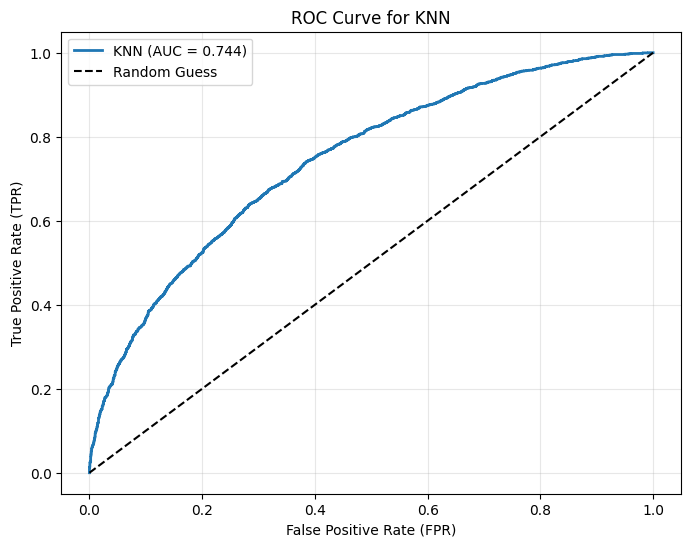

In [18]:
# Compute ROC curve & AUC score

y_test_bin = y_test.map({'e': 0, 'p': 1})

fpr_knn, tpr_knn, _ = roc_curve(y_test_bin, y_proba_knn)
auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {auc_knn:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for KNN")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Stack Ensemble

In [20]:
# all features are categorical
categorical_features = X_train.columns.tolist()

ohe_stack = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocess_stack = ColumnTransformer(
    transformers=[
        ("cat", ohe_stack, categorical_features)
    ]
)

In [ ]:
# base models for stacking
base_estimators = [
    ("lr",  LogisticRegression(max_iter=2000, solver="lbfgs", n_jobs=-1)),
    ("lda", LinearDiscriminantAnalysis()),
    ("qda", QuadraticDiscriminantAnalysis()),
    ("knn", KNeighborsClassifier(
        n_neighbors=20,
        weights="distance",
        n_jobs=-1
    )),
    ("rf",  RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    )),
    ("gb",  GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=3,
        random_state=42)),
    ("svm", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        class_weight="balanced",
        random_state=42
    )),
]

final_estimator = LogisticRegression(max_iter=1000)

In [ ]:
# ----- Stack Ensemble -----
from sklearn.ensemble import StackingClassifier

stack_clf = Pipeline(steps=[
    ("preprocess", preprocess_stack),
    ("stack", StackingClassifier(
        estimators=base_estimators,
        final_estimator=final_estimator,
        stack_method="predict_proba",  
        n_jobs=-1
    ))
])

In [27]:
# fit on training data
stack_clf.fit(X_train, y_train)

y_proba_stack = stack_clf.predict_proba(X_test)[:, 1]
threshold = 0.27
y_pred_stack = np.where(y_proba_stack >= threshold, "p", "e")

print("Stacked Model Accuracy:", accuracy_score(y_test, y_pred_stack))

cm_stack = confusion_matrix(y_test, y_pred_stack, labels=["e", "p"])
TN, FP, FN, TP = cm_stack.ravel()

TPR = TP / (TP + FN) 
FNR = FN / (TP + FN)   
FPR = FP / (FP + TN)
TNR = TN / (TN + FP)

print("\nStacked Model Confusion Matrix:")
print(cm_stack)

print(f"\nTrue Positive Rate (TPR): {TPR:.4f}")
print(f"False Negative Rate (FNR): {FNR:.4f}")
print(f"False Positive Rate (FPR): {FPR:.4f}")
print(f"True Negative Rate (TNR): {TNR:.4f}")

Stacked Model Accuracy: 0.7018083878414775

Stacked Model Confusion Matrix:
[[1575 1296]
 [ 254 2073]]

True Positive Rate (TPR): 0.8908
False Negative Rate (FNR): 0.1092
False Positive Rate (FPR): 0.4514
True Negative Rate (TNR): 0.5486


In [28]:
f2 = fbeta_score(y_test, y_pred_stack, beta=2, pos_label="p")
print("f2:",f2)

f2: 0.8176224658830954


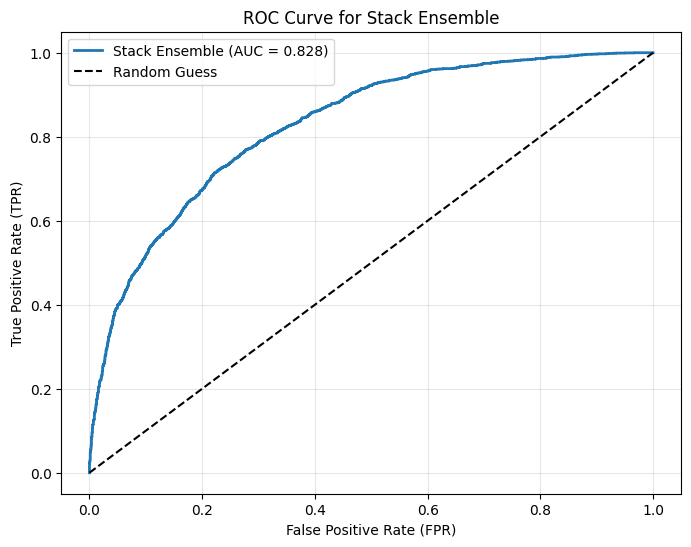

In [24]:
# probability of positive class 'p'
y_proba_stack = stack_clf.predict_proba(X_test)[:, 1]

# map labels to 0/1: e -> 0, p -> 1
y_test_bin = y_test.map({"e": 0, "p": 1})

fpr_stack, tpr_stack, _ = roc_curve(y_test_bin, y_proba_stack)
auc_stack = auc(fpr_stack, tpr_stack)

plt.figure(figsize=(8, 6))
plt.plot(fpr_stack, tpr_stack, label=f"Stack Ensemble (AUC = {auc_stack:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for Stack Ensemble")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Plotting

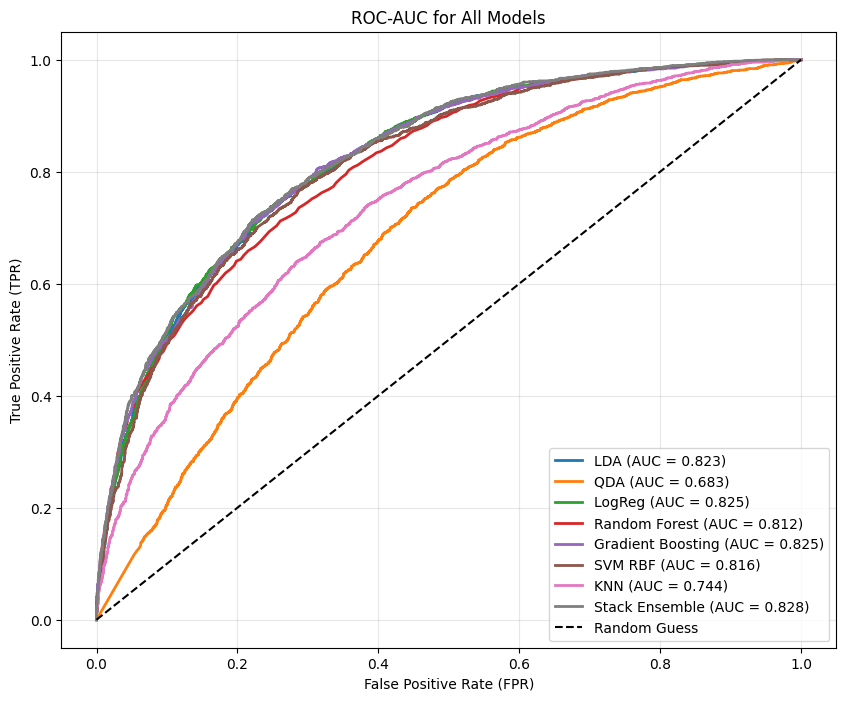

In [26]:
# ===== Plot All ROC Curves Together =====
plt.figure(figsize=(10, 8))

plt.plot(fpr_lda,   tpr_lda,   label=f"LDA (AUC = {auc_lda:.3f})", linewidth=2)
plt.plot(fpr_qda,   tpr_qda,   label=f"QDA (AUC = {auc_qda:.3f})", linewidth=2)
plt.plot(fpr_logreg, tpr_logreg, label=f"LogReg (AUC = {auc_logreg:.3f})", linewidth=2)
plt.plot(fpr_rf,    tpr_rf,    label=f"Random Forest (AUC = {auc_rf:.3f})", linewidth=2)
plt.plot(fpr_gb,    tpr_gb,    label=f"Gradient Boosting (AUC = {auc_gb:.3f})", linewidth=2)
plt.plot(fpr_svm,   tpr_svm,   label=f"SVM RBF (AUC = {auc_svm:.3f})", linewidth=2)
plt.plot(fpr_knn,   tpr_knn,   label=f"KNN (AUC = {auc_knn:.3f})", linewidth=2)
plt.plot(fpr_stack, tpr_stack, label=f"Stack Ensemble (AUC = {auc_stack:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], "k--", label="Random Guess")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC-AUC for All Models")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()